# importing necessary libararies

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib
import pickle 

# reading dataset

In [24]:
dataset = pd.read_csv('../Datasets/regression.csv')
dataset.head()

,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,02-04-2019,NaN,NaN,Marla,4.0,0-5 Marla
1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,05-04-2019,NaN,NaN,Marla,5.6,5-10 Marla
2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,07-17-2019,NaN,NaN,Marla,8.0,5-10 Marla
3,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,04-05-2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,841645,3226,https://www.zameen.com/Property/dha_valley_dha...,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,07-10-2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla


# Data Preprocessing

In [25]:
dataset.isna().sum()

# Droping id's and unique data of examples before dropping duplicates

drop_colums=['property_id', 'location_id', 'page_url']
df = dataset.drop(columns= drop_colums, axis=1)

df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,02-04-2019,NaN,NaN,Marla,4.0,0-5 Marla
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,05-04-2019,NaN,NaN,Marla,5.6,5-10 Marla
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,07-17-2019,NaN,NaN,Marla,8.0,5-10 Marla
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,04-05-2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,07-10-2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,9.6 Marla,For Sale,6,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168442,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,8 Marla,For Sale,3,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,8.0,5-10 Marla
168443,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,9.6 Marla,For Sale,6,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168444,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,7.8 Marla,For Sale,3,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,7.8,5-10 Marla


In [26]:
df = df.drop_duplicates()

df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,02-04-2019,NaN,NaN,Marla,4.0,0-5 Marla
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,05-04-2019,NaN,NaN,Marla,5.6,5-10 Marla
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,07-17-2019,NaN,NaN,Marla,8.0,5-10 Marla
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,04-05-2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,07-10-2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,9.6 Marla,For Sale,6,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168442,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,8 Marla,For Sale,3,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,8.0,5-10 Marla
168443,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,9.6 Marla,For Sale,6,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,9.6,5-10 Marla
168444,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,7.8 Marla,For Sale,3,07-18-2019,Al Shahab Enterprises,Shahmir,Marla,7.8,5-10 Marla


In [27]:
# droping N/A values

df = df.dropna()

df.isna().sum()

property_type    0
price            0
location         0
city             0
province_name    0
latitude         0
longitude        0
baths            0
area             0
purpose          0
bedrooms         0
date_added       0
agency           0
agent            0
Area Type        0
Area Size        0
Area Category    0
dtype: int64

In [28]:
# chagning marla and kanal to meter to keep consistent in data representing

marla_mask = df['Area Type'] == "Marla"
df.loc[marla_mask, 'Area Size'] *= 25.2929
df.loc[~marla_mask, 'Area Size'] *= 505.857
df=df.drop(columns=['Area Type'],axis=1)
df

,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Size,Area Category
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,07-10-2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,202.34320,5-10 Marla
7,Flat,7800000,E-11,Islamabad,Islamabad Capital,33.698244,72.984238,2,6.2 Marla,For Sale,2,05-05-2019,Ettemad Enterprises,Balqiaz Marwat,156.81598,5-10 Marla
8,House,50000000,DHA Defence,Islamabad,Islamabad Capital,33.540894,73.095732,7,1 Kanal,For Sale,7,10-19-2018,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,505.85700,1-5 Kanal
9,Penthouse,40000000,F-11,Islamabad,Islamabad Capital,33.679211,72.988787,5,1 Kanal,For Sale,5,06-27-2019,Crown Associate,Abrar Ahmed,505.85700,1-5 Kanal
10,Flat,35000000,Diplomatic Enclave,Islamabad,Islamabad Capital,33.728873,73.119628,3,7.1 Marla,For Sale,3,06-03-2019,Al Sahar Estate,Zahid H. Usmani,179.57959,5-10 Marla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,House,26500000,Gadap Town,Karachi,Sindh,25.029909,67.137192,0,9.6 Marla,For Sale,6,07-18-2019,Al Shahab Enterprises,Shahmir,242.81184,5-10 Marla
168442,House,12500000,Gadap Town,Karachi,Sindh,25.017951,67.136393,0,8 Marla,For Sale,3,07-18-2019,Al Shahab Enterprises,Shahmir,202.34320,5-10 Marla
168443,House,27000000,Gadap Town,Karachi,Sindh,25.015384,67.116330,0,9.6 Marla,For Sale,6,07-18-2019,Al Shahab Enterprises,Shahmir,242.81184,5-10 Marla
168444,House,11000000,Gadap Town,Karachi,Sindh,25.013265,67.120818,0,7.8 Marla,For Sale,3,07-18-2019,Al Shahab Enterprises,Shahmir,197.28462,5-10 Marla


In [29]:
# Define numeric columns
numeric_columns = ['price', 'baths', 'Area Size', 'bedrooms']

# Function to visualize data distribution using box plots

def visualize_boxplot(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(y=df[col])
        plt.title('Box Plot - ' + col)
        plt.ylabel(col)
        plt.show()

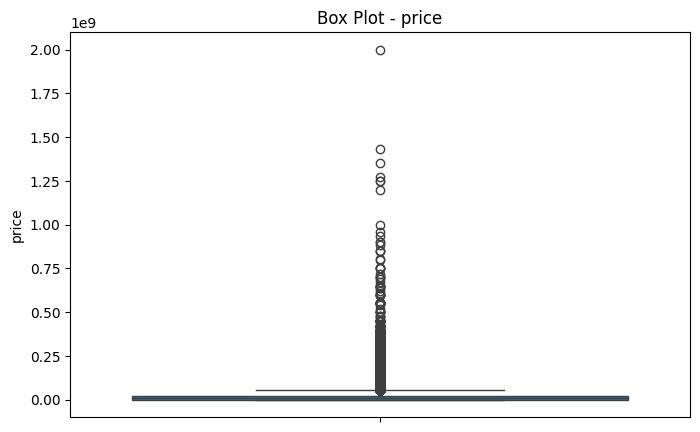

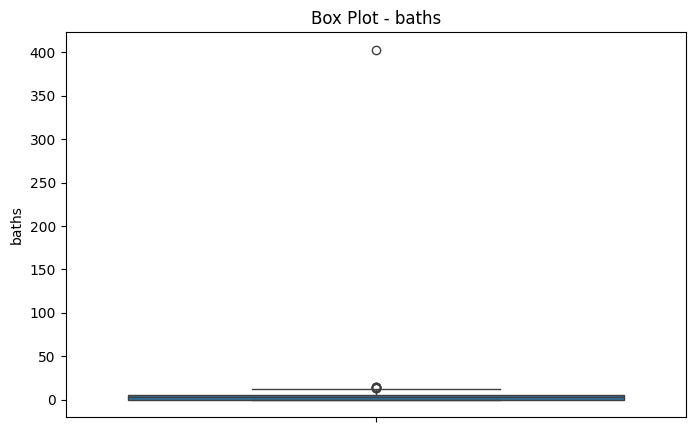

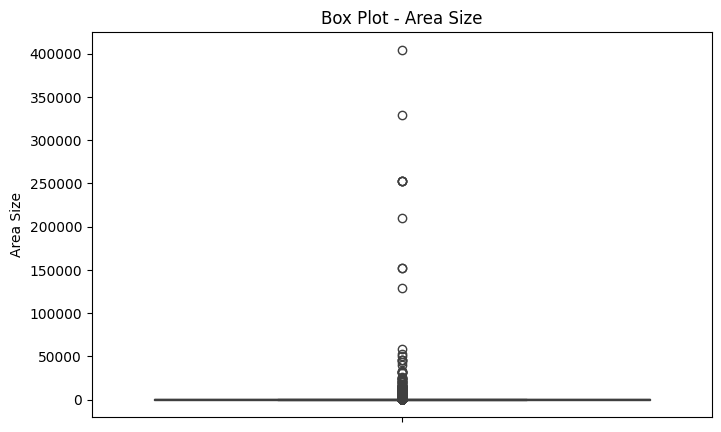

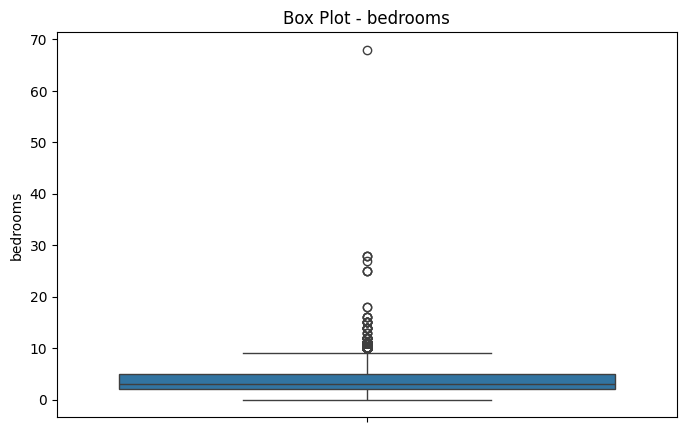

In [30]:
# Visualize data distribution using box plots before handling outliers
visualize_boxplot(df, numeric_columns)



new_df=df.copy()
for col in numeric_columns:
    Q1 = new_df[col].quantile(0.25)
    Q3 = new_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    new_df[col] = np.where(
        new_df[col] > upper_bound,
        upper_bound,
        np.where(
            new_df[col] < lower_bound,
            lower_bound,
            new_df[col]
        )
    )
df = new_df

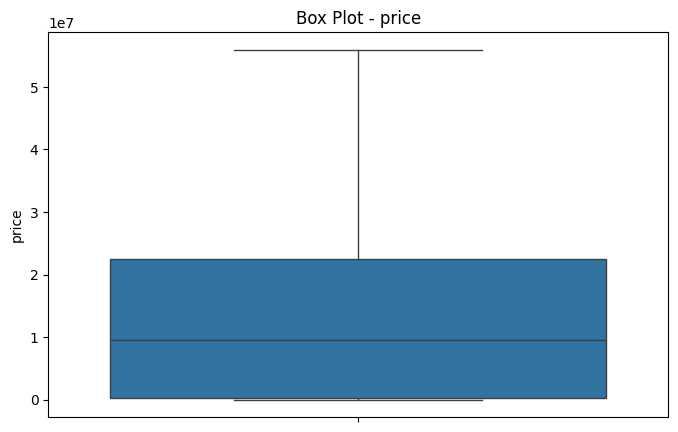

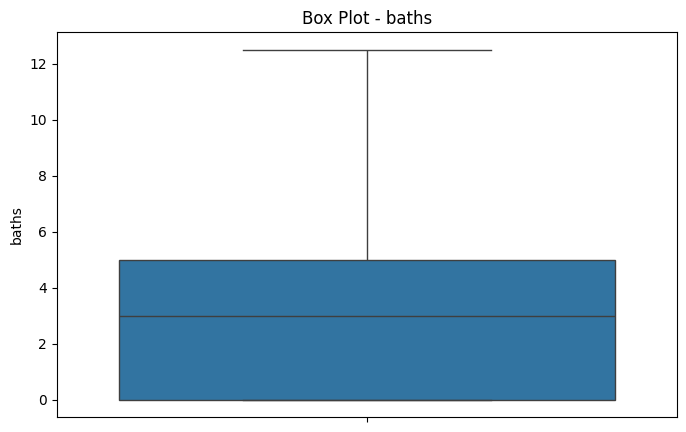

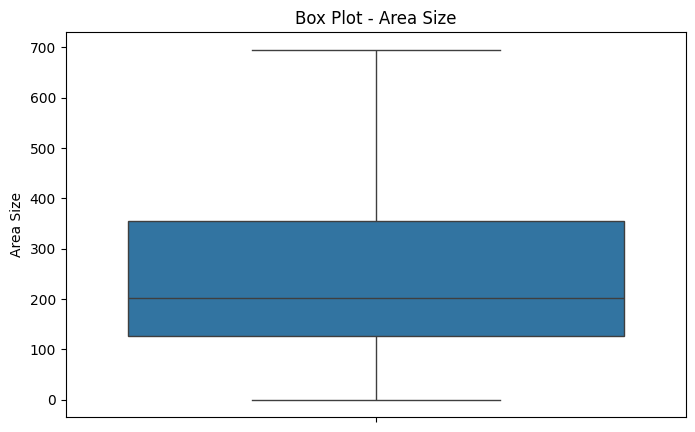

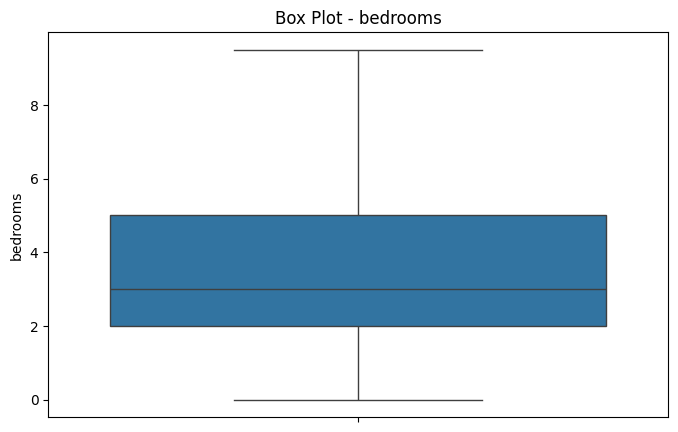

In [31]:
# visualize df after removing outliers
visualize_boxplot(df, numeric_columns)

# Data selection

In [32]:
# droping unneeded features

drop_colums=['date_added','Area Category', 'area']
df = df.drop(columns= drop_colums, axis=1)

df

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Size
4,House,7000000.0,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3.0,For Sale,3.0,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,202.34320
7,Flat,7800000.0,E-11,Islamabad,Islamabad Capital,33.698244,72.984238,2.0,For Sale,2.0,Ettemad Enterprises,Balqiaz Marwat,156.81598
8,House,50000000.0,DHA Defence,Islamabad,Islamabad Capital,33.540894,73.095732,7.0,For Sale,7.0,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,505.85700
9,Penthouse,40000000.0,F-11,Islamabad,Islamabad Capital,33.679211,72.988787,5.0,For Sale,5.0,Crown Associate,Abrar Ahmed,505.85700
10,Flat,35000000.0,Diplomatic Enclave,Islamabad,Islamabad Capital,33.728873,73.119628,3.0,For Sale,3.0,Al Sahar Estate,Zahid H. Usmani,179.57959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,House,26500000.0,Gadap Town,Karachi,Sindh,25.029909,67.137192,0.0,For Sale,6.0,Al Shahab Enterprises,Shahmir,242.81184
168442,House,12500000.0,Gadap Town,Karachi,Sindh,25.017951,67.136393,0.0,For Sale,3.0,Al Shahab Enterprises,Shahmir,202.34320
168443,House,27000000.0,Gadap Town,Karachi,Sindh,25.015384,67.116330,0.0,For Sale,6.0,Al Shahab Enterprises,Shahmir,242.81184
168444,House,11000000.0,Gadap Town,Karachi,Sindh,25.013265,67.120818,0.0,For Sale,3.0,Al Shahab Enterprises,Shahmir,197.28462


# Data Scaleing

In [48]:
# Intializing a scaler to scale our numreic data
scaler = StandardScaler()

# # Scaling our numeric data
# df['price']=scaler.fit_transform(df[['price']])
# df['baths']=scaler.fit_transform(df[['baths']])
# df['bedrooms']=scaler.fit_transform(df[['bedrooms']])
# df['Area Size']=scaler.fit_transform(df[['Area Size']])
# df['latitude']=scaler.fit_transform(df[['latitude']])
# df['longitude']=scaler.fit_transform(df[['longitude']])

df[['price', 'baths', 'bedrooms', 'Area Size', 'latitude', 'longitude']]=scaler.fit_transform(df[['price', 'baths', 'bedrooms', 'Area Size', 'latitude', 'longitude']])

with open('scaler.pkl','wb') as f :
    pickle.dump(scaler, f) 
    
# displaying the dataset after scaling numeric data
df.head()

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Size
4,0.299512,-0.488322,0.650838,-0.277787,-0.277787,0.948778,0.642994,0.055600,0.356178,-0.115082,0.051162,0.015431,-0.328073
7,-0.383268,-0.442191,-0.480151,-0.277787,-0.277787,1.003104,0.541430,-0.372944,0.356178,-0.636644,-0.240975,-0.070751,-0.583895
8,0.299512,1.991237,0.650838,-0.277787,-0.277787,0.961538,0.577140,1.769776,0.356178,1.971166,0.051162,0.015431,1.377403
9,-0.052760,1.414595,-0.208267,-0.277787,-0.277787,0.998077,0.542887,0.912688,0.356178,0.928042,0.116677,0.135433,1.377403
10,-0.383268,1.126275,-0.249398,-0.277787,-0.277787,1.011196,0.584794,0.055600,0.356178,-0.115082,-0.070043,0.270352,-0.455984


# Encoding Categorical Data

In [49]:
# Let's say 'property_type' is the categorical variable you want to encode

# Using pandas' get_dummies function to perform one-hot encoding
categorical_columns = ['property_type', 'city', 'province_name', 'purpose', 'location', 'agent', 'agency']

encoder = ce.TargetEncoder(cols=categorical_columns)
df = encoder.fit_transform(df,df['price'])

with open('encoder.pkl','wb') as f :
    pickle.dump(encoder, f) 

df

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Size
4,0.299512,-0.488322,0.650838,-0.277787,-0.277787,0.948778,0.642994,0.055600,0.356178,-0.115082,0.051162,0.015431,-0.328073
7,-0.383268,-0.442191,-0.480151,-0.277787,-0.277787,1.003104,0.541430,-0.372944,0.356178,-0.636644,-0.240975,-0.070751,-0.583895
8,0.299512,1.991237,0.650838,-0.277787,-0.277787,0.961538,0.577140,1.769776,0.356178,1.971166,0.051162,0.015431,1.377403
9,-0.052760,1.414595,-0.208267,-0.277787,-0.277787,0.998077,0.542887,0.912688,0.356178,0.928042,0.116677,0.135433,1.377403
10,-0.383268,1.126275,-0.249398,-0.277787,-0.277787,1.011196,0.584794,0.055600,0.356178,-0.115082,-0.070043,0.270352,-0.455984
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,0.299512,0.636129,-0.383051,0.038174,0.038174,-1.286770,-1.331319,-1.230032,0.356178,1.449604,0.144200,0.077566,-0.100676
168442,0.299512,-0.171169,-0.383051,0.038174,0.038174,-1.289929,-1.331575,-1.230032,0.356178,-0.115082,0.144200,0.077566,-0.328073
168443,0.299512,0.664961,-0.383051,0.038174,0.038174,-1.290607,-1.338001,-1.230032,0.356178,1.449604,0.144200,0.077566,-0.100676
168444,0.299512,-0.257666,-0.383051,0.038174,0.038174,-1.291167,-1.336564,-1.230032,0.356178,-0.115082,0.144200,0.077566,-0.356498


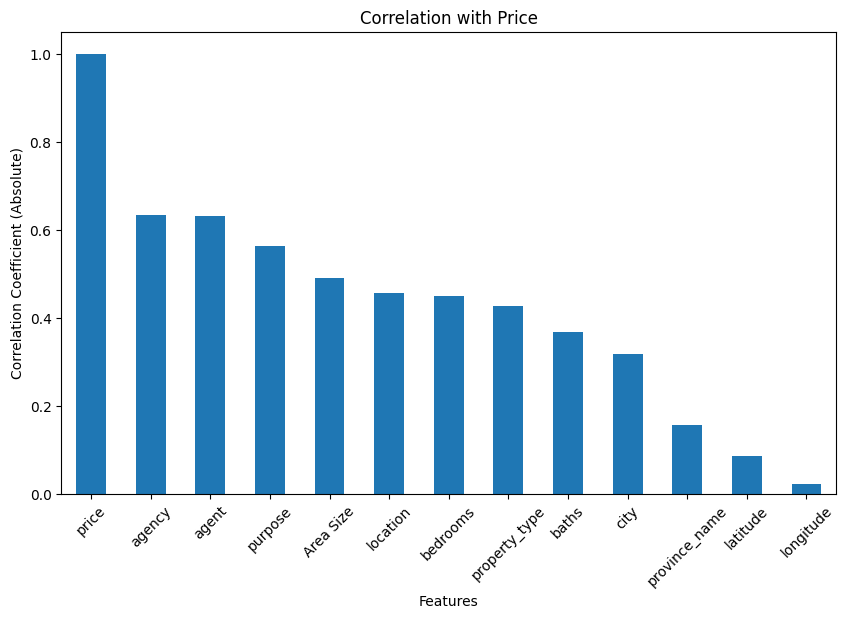

In [35]:
# Compute Pearson correlation coefficients
correlation_with_price = df.corr()['price'].abs().sort_values(ascending=False)

# Plotting the correlation coefficients
plt.figure(figsize=(10, 6))
correlation_with_price.plot(kind='bar')
plt.title('Correlation with Price')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient (Absolute)')
plt.xticks(rotation=45)
plt.show()

# splitting data

In [36]:
X = df.drop(columns=['price'], axis=1)
y = df[['price']]

X.shape, y.shape

((111272, 12), (111272, 1))

In [37]:

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((89017, 12), (89017, 1))

# Model Training

In [38]:

# y_train = y_train.values.ravel()

# svr = SVR(kernel='rbf')
# svr.fit(X_train, y_train)

# joblib.dump(svr, 'models/svrmodel.pkl')



['models/svrmodel.pkl']

In [39]:
svr_model = joblib.load('models/svrmodel.pkl')

y_pred = svr_model.predict(X_test)

# Model Evalution

In [40]:
r2 = r2_score(y_test, y_pred)
test_mse_scaled = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2}\nmean_square_error_test: {test_mse_scaled}")

R-squared: 0.923901492473348
mean_square_error_test: 0.07549592113844214


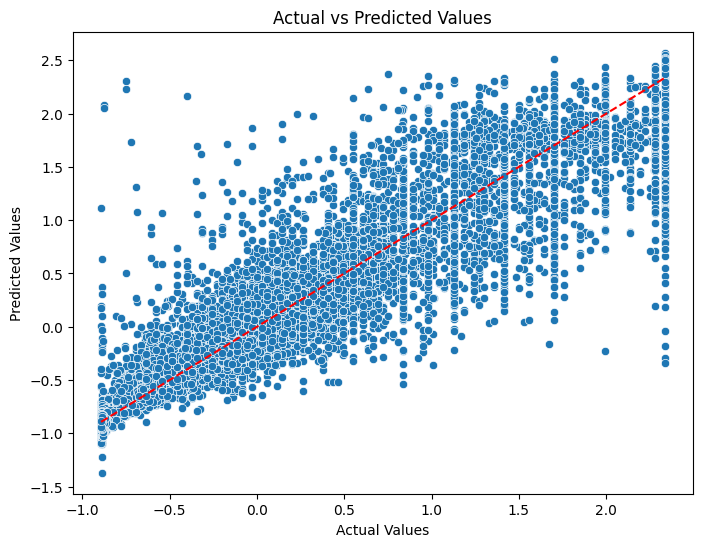

In [41]:
y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Diagonal line representing perfect prediction
plt.show()

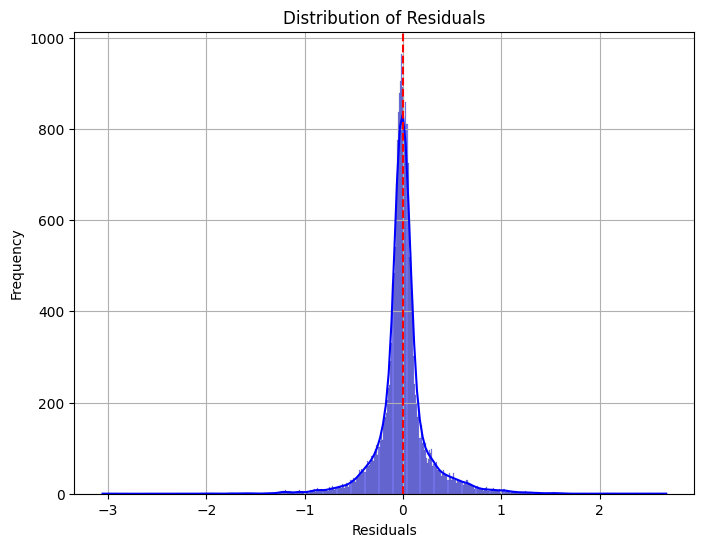

In [42]:
# Assuming svr_model is your trained SVR model and X_test, y_test are your test features and labels
predicted_values = y_pred
residuals = y_true - predicted_values

# Plotting the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)  # Add grid lines for better readability
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


In [43]:
y_pred_df = pd.DataFrame(y_pred, columns=['price'])
y_pred_df

,price
0,-0.314556
1,0.703571
2,-0.881665
3,-0.835908
4,-0.090449
...,...
22250,-0.247231
22251,-0.886040
22252,0.364792
22253,-0.504533


In [44]:
y_true_df = pd.DataFrame(y_true, columns=['price'])
y_true_df

,price
0,-0.200001
1,0.722625
2,-0.888944
3,-0.871789
4,0.030655
...,...
22250,-0.200001
22251,-0.890703
22252,0.232480
22253,-0.545986


# hesitation is defeat